In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import torch
import itertools
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import matplotlib.gridspec as gridspec
import importlib
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from argparse import ArgumentParser
import itertools
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline
# ## Initialize Model
from rnn_lib import utils
from rnn_lib.base_rnn import RNNCell
from rnn_lib.model import Model
from rnn_lib.dense_layers import DenseLayer
from rnn_lib.init_policies import W_TorchInit, U_TorchInit

#### song
from rnn_lib.dense_layers import ColumnEiDense
from rnn_lib.song_rnn import ColumnEiCell
from rnn_lib.init_policies import ColumnEi_FirstCell_U_InitPolicy, ColumnEiCell_W_InitPolicy
from rnn_lib.update_policies import ColumnEiSGD_Clip, ColumnEiDenseSGD

#### danns
from rnn_lib.dense_layers import EiDense
from rnn_lib.dann_rnn import EiRNNCell
from rnn_lib.init_policies import EiDenseWeightInit_WexMean, EiRNNCell_W_InitPolicy
from rnn_lib.update_policies import EiRNN_cSGD_UpdatePolicy2, DalesANN_cSGD_UpdatePolicy2

In [ ]:
# Load saved models and results
PLAYGROUND_DIR = "~/logs/EI_RLDM/decision_making"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"
dataset_path = f"{PLAYGROUND_DIR}/datasets/decision_making_data.npz"
data = np.load(dataset_path)
inputs_series = data['inputs_series']
targets_series = data['targets_series']
coherence_series = data['coherence_series']
mask_series = data['mask_series']

# ## Set Hyperparameters
input_features = 2
n_output_classes = 2
n_hidden = 125
device = 'cpu'

test_size = 100
valid_size = 100
num_batches = 1 #len(data_train) // batch_size
decision_threshold = 0.25
stimulus_onset = 10 
stimulus_duration = 21

n_epochs = 600  # Adjust based on training epochs
batch_size = 200
n_seeds = 10
seeds = [i for i in range(n_seeds)]
grad_clip_list = [1]
rad_list = [1.2]
lr_list = [4e-4]
# lr_list = [round(learning_rate, 6) for learning_rate in lr_list]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list))
(seed, _, _, rad, ei_ratio) = para_comb[0]
learning_rates = { "rnn": 6e-4,
    "colei": 6e-4,
    "danns": 2e-4
    }

grad_clips = { "rnn": 1,
    "colei": 1,
    "danns": 1
    }


In [4]:
# Function to load the trained RNN model
def load_model(model_class, model_save_path, device='cpu'):
    model = model_class()
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval()
    return model

In [5]:
# Load Dataset
data_train = inputs_series[:-valid_size-test_size]
targets_train = targets_series[:-valid_size-test_size]
masks_train = mask_series[:-valid_size-test_size]
coherence_train = coherence_series[:-valid_size-test_size]

data_valid = torch.from_numpy(inputs_series[-valid_size-test_size:-test_size]).float().to(device)
targets_valid = torch.from_numpy(targets_series[-valid_size-test_size:-test_size]).float().to(device)

data_test = torch.from_numpy(inputs_series[-test_size:]).float().to(device)
targets_test = torch.from_numpy(targets_series[-test_size:]).float().to(device)

In [ ]:
# ## Initialize Model

# Initialize Model
models = {
    # "rnn": {}, 
    # "colei": {},
    "danns": {}
}
for model_type in models.keys():
    grad_clip = grad_clips[model_type]
    learning_rate = learning_rates[model_type]
    # Model save path
    model_save_path_root = Path(f"{models_dir}/batch_size-{batch_size}/seed-{seed}")
    if model_type == 'colei':   
        model_save_path = model_save_path_root / f"dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_adam.pth"
    else:
        model_save_path = model_save_path_root / f"dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_adam.pth"
    # Set model type ('rnn' for vanilla RNN, 'colei' for Song et al. model)
    if model_type == "rnn":
        cells = [RNNCell(input_features, n_hidden, nonlinearity=F.relu, i2h_init_policy=U_TorchInit(), h2h_init_policy=W_TorchInit()),
                DenseLayer(n_hidden, n_output_classes, nonlinearity=None)]
    elif model_type == "colei":
        pixel_mean = (data_train * masks_train[..., np.newaxis]).mean()
        cells = [ColumnEiCell(input_features, (n_hidden, ei_ratio),
                            nonlinearity=F.relu, 
                            i2h_init_policy=ColumnEi_FirstCell_U_InitPolicy(pixel_mean=pixel_mean), 
                            h2h_init_policy=ColumnEiCell_W_InitPolicy(radius=rad), 
                            update_policy=ColumnEiSGD_Clip(max=grad_clip)),
                ColumnEiDense(n_hidden, (n_output_classes, ei_ratio),
                            nonlinearity=None, update_policy=ColumnEiDenseSGD(max=grad_clip))
                ]
    elif model_type == "danns":
        cells = [EiRNNCell(input_features, n_hidden, max(n_hidden//(ei_ratio+1), 1), max(n_hidden//(ei_ratio+1), 1),
                       nonlinearity=F.relu,
                       h2h_init_policy=EiRNNCell_W_InitPolicy(numerator=1/3, random=False)),
            EiDense(n_hidden, n_output_classes, max(n_output_classes//(ei_ratio+1),1),
                     nonlinearity=None, 
                     weight_init_policy=EiDenseWeightInit_WexMean(numerator=2))
            ]
        for cell in cells[-1:]:
            cell.update_policy = DalesANN_cSGD_UpdatePolicy2(max_grad_norm=grad_clip)
        for cell in cells[:-1]:
            cell.update_policy = EiRNN_cSGD_UpdatePolicy2(max_grad_norm=grad_clip)
    else:
        raise ValueError("Invalid model type")
    model = Model(cells)
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    models[model_type]["model"] = model

In [7]:
# Evaluate test accuracy and extract post-stimulus activity
for model_type in models.keys():
    model = models[model_type]["model"]
    model.eval()
    model.reset_hidden(batch_size=test_size)

    # {model: models_output_vs_targets[model]["outputs_test"][0] for model in models}
    outputs_test = []
    for t in range(data_test.shape[1]):
        test_output = model(data_test[:, t, :]).detach()
        outputs_test.append(test_output.cpu().numpy())

    # Convert to numpy
    outputs_test = np.transpose(np.array(outputs_test), axes=[1, 0, 2])  # Shape: (batch, time, features)
    # Extract unit activity at the time-step after stimulus offset
    stimulus_offset = stimulus_onset + stimulus_duration
    unit_activity = outputs_test[:, stimulus_offset, :]
    choices = np.argmax(targets_test[:, stimulus_offset, :].cpu().numpy(), axis=-1)

    # Function to compute AUC-ROC for each unit
    def compute_auc_roc(unit_activity, choices, n_permutations=150, alpha=0.05):
        n_units = unit_activity.shape[-1]
        auc_values = np.zeros(n_units)
        p_values = np.zeros(n_units)
        suffled_choices = np.random.permutation(choices)
        for i in range(n_units):
            fpr, tpr, _ = roc_curve(choices, unit_activity[:, i])
            auc_values[i] = auc(fpr, tpr) - 0.5  # Centered around 0.5
            
            # Permutation test
            shuffled_aucs = []
            for _ in range(n_permutations):
                fpr_perm, tpr_perm, _ = roc_curve(suffled_choices, unit_activity[:, i])
                shuffled_aucs.append(auc(fpr_perm, tpr_perm) - 0.5)
            
            shuffled_aucs = np.array(shuffled_aucs)
            lower, upper = np.percentile(shuffled_aucs, [100 * alpha / 2, 100 * (1 - alpha / 2)])
            p_values[i] = (auc_values[i] < lower) or (auc_values[i] > upper)
        
        return auc_values, p_values

    # Compute AUC-ROC for each unit
    auc_values, choice_selective_units = compute_auc_roc(unit_activity, choices)
    models[model_type]["auc_values"] = auc_values
    models[model_type]["choice_selective_units"] = choice_selective_units
    models[model_type]["outputs_test"] = outputs_test

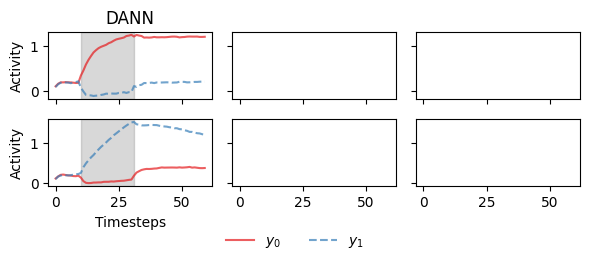

In [8]:
# Function to plot unit activities with stimulus shading

labels = {
          "rnn": "RNN",
          "colei": "ColEI",
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]

fig, axes = plt.subplots(2, 3, figsize=(6, 2.5), sharex=True, sharey="row")


# sample_indices = [np.random.randint(0, 5), np.random.randint(95, 100)]
sample_indices = [99, 0]
time_steps = np.arange(models[model_type]["outputs_test"].shape[1])
for k in range(len(sample_indices)):
    for i, model_type in enumerate(models.keys()):
        for j in range(2):
            axes[k, i].plot(time_steps, models[model_type]["outputs_test"][sample_indices[k], :, j], ls=linestyles[j], c=colors[j], label=r"$"+ f"y_{j}" + r"$", alpha=0.7)
        
        axes[k, i].axvspan(stimulus_onset, stimulus_offset, color='gray', alpha=0.3)
        
        # axes[k, i].legend()
        if k == 0:
            axes[k, i].set_title(labels[model_type])
        if k == 1:
            axes[k, i].set_xlabel('Timesteps')
    axes[k, 0].set_ylabel('Activity')
# axes[k, i].legend()

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center', frameon=False,
ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

In [9]:
model = models["danns"]["model"]  # or "colei", "danns"
model.eval()
model.reset_hidden(batch_size=data_test.shape[0])

outputs_test = []

for t in range(data_test.shape[1]):
    out = model(data_test[:, t, :]).detach().cpu().numpy()
    outputs_test.append(out)

# Convert shape to (time, batch, output_dim)
outputs_test = np.transpose(np.array(outputs_test), axes=[1, 0, 2])

In [ ]:
# Use this to collect hidden states 
def get_hidden_states(model, data_test):
    model.eval()
    rnn_cell = model[0]  # the RNNCell
    rnn_cell.reset_hidden(batch_size=data_test.shape[0])

    hidden_states = []
    input_to_hidden_states = []
    for t in range(data_test.shape[1]):
        x_t = data_test[:, t, :]
        input_to_hidden_states.append(x_t.detach().cpu().numpy())
        h_t = rnn_cell(x_t)  # updates rnn_cell.h internally
        hidden_states.append(h_t.detach().cpu().numpy())

    # shape: (time, batch, units) -> (batch, time, units)
    hidden_states = np.transpose(np.array(hidden_states), [1, 0, 2])
    input_to_hidden_states = np.transpose(np.array(input_to_hidden_states), [1, 0, 2])
    return hidden_states, input_to_hidden_states
hidden_states, input_to_hidden_states = get_hidden_states(models["danns"]["model"], data_test)
print("Hidden state shape:", hidden_states.shape)  # should be (batch, time, n_hidden)
print("Input state shape:", input_to_hidden_states.shape)  # should be (batch, time, n_hidden)


In [24]:
# import rnn_lib
# rnn_lib = importlib.reload(rnn_lib)
# rnn_lib.base_rnn = importlib.reload(rnn_lib.base_rnn)
# from rnn_lib.base_rnn import RNNCell
# rnn_lib.rnn_wrapper_danns = importlib.reload(rnn_lib.rnn_wrapper_danns)
# from rnn_lib.rnn_wrapper_danns import RNNCellWrapperDANN
# import analyzer
# analyzer = importlib.reload(analyzer)
# from analyzer import FixedPoint  # Your existing class

import rnn_lib
rnn_lib.base_rnn = importlib.reload(rnn_lib.base_rnn)
from rnn_lib.base_rnn import RNNCell
import rnn_lib.rnn_wrapper as rnn_wrapper
rnn_lib.rnn_wrapper = importlib.reload(rnn_lib.rnn_wrapper)
from rnn_lib.rnn_wrapper import RNNCellWrapper
import analyzer
analyzer = importlib.reload(analyzer)
from analyzer import FixedPoint  # Your existing class

# Grab RNN cell from your model
rnn_cell = models["danns"]["model"][0]  # assuming first layer is the RNNCell
wrapped_cell = RNNCellWrapper(rnn_cell)

# Create FixedPoint analyzer
fp_finder = FixedPoint(wrapped_cell, device=device)

# Use constant input (shape: [1, 1, input_dim])
# const_input = torch.tensor([[[0.5, 0.5]]], dtype=torch.float32).to(device)

# Collect fixed points
# fixed_points = []
# n_fixed_points = 20
# time_steps = 12 # pre-stimulus

# Use constant input (shape: [1, 1, input_dim])
# const_input = torch.tensor([[[0.5, 0.5]]], dtype=torch.float32).to(device)

# Collect fixed points
fixed_points_list = []
fixed_point_indices = []
choices = []
speeds_list = []
# n_fixed_points = 20
# time_steps = 12 # pre-stimulus
trial_list = [0, 25, 50, 75, 99]
timestep_list = [0, 3, 5, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 59]
for i in trial_list:
    for t in timestep_list:
        
        # Initialize from test hidden state
    
        h0 = torch.from_numpy(hidden_states[i, t, :]).unsqueeze(0).float().to(device)  
        x = torch.from_numpy(input_to_hidden_states[i, t, :]).unsqueeze(0).float().to(device)  
        
        fp, speed, ok = fp_finder.find_fixed_point(h0, x, view=False)
        if ok:
            fixed_points_list.append(fp.detach().cpu().numpy())
            fixed_point_indices.append((i, t))
            speeds_list.append(speed)
            choices.append(np.argmax(outputs_test[i, stimulus_offset, :]))
        print(f'i:{i}, t:{t}, speed:{speed}, ok:{ok}')

fixed_points = np.stack(fixed_points_list)
speeds = np.stack(speeds_list)
fixed_points = fixed_points.squeeze(1)

Forced exit at max_epochs, final speed=0.011623
i:0, t:0, speed:0.011623251251876354, ok:False
i:0, t:3, speed:0.0019410619279369712, ok:True
i:0, t:5, speed:0.009137989021837711, ok:True
i:0, t:8, speed:0.00561597291380167, ok:True
Forced exit at max_epochs, final speed=0.058438
i:0, t:10, speed:0.05843767151236534, ok:False
Forced exit at max_epochs, final speed=0.053305
i:0, t:15, speed:0.05330505594611168, ok:False
Forced exit at max_epochs, final speed=0.050877
i:0, t:20, speed:0.05087748542428017, ok:False
Forced exit at max_epochs, final speed=0.046602
i:0, t:25, speed:0.04660200700163841, ok:False
Forced exit at max_epochs, final speed=0.040896
i:0, t:30, speed:0.04089570418000221, ok:False
i:0, t:35, speed:0.003962755668908358, ok:True
i:0, t:40, speed:0.008391161449253559, ok:True
i:0, t:45, speed:0.009230931289494038, ok:True
i:0, t:50, speed:0.006824883166700602, ok:True
i:0, t:55, speed:0.009061930701136589, ok:True
i:0, t:59, speed:0.003872636938467622, ok:True
Forced exi

In [25]:
fixed_points = np.stack(fixed_points_list)
speeds = np.stack(speeds_list)
fixed_points = fixed_points.squeeze(1)

In [ ]:
# --- Save fixed points ---
# Build a path matching your model naming logic
if model_type == "colei":
    fixedpoints_save_path = f"{model_save_path_root}/fixedpoints_dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_adam.npz"
else:
    fixedpoints_save_path = f"{model_save_path_root}/fixedpoints_dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_adam.npz"

# Make sure directory exists
model_save_path_root.mkdir(parents=True, exist_ok=True)

# Save fixed points as a compressed .npz file
np.savez(fixedpoints_save_path, fixed_points=fixed_points)

print(f"Fixed points saved at {fixedpoints_save_path}")


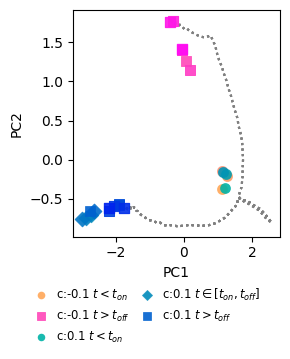

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib.colors import Normalize
import torch

def plot_fixed_points_with_dynamics_2d(hidden_states, fixed_points, fixed_point_indices, outputs_test,
                                        coherence_series, phases, stimulus_offset, fp_finder,
                                        input_to_hidden_states):
    nT = hidden_states.shape[1]
    # unique_trials = sorted(set(i for i, _ in fixed_point_indices))
    unique_trials = [i for i, _ in fixed_point_indices]
    background_states = hidden_states[unique_trials].reshape(-1, hidden_states.shape[-1])

    # --- PCA 2D ---
    pca = PCA(n_components=2).fit(background_states)
    # pca = PCA(n_components=2).fit(hidden_states.reshape(-1, hidden_states.shape[-1]))
    pc_trajectory = pca.transform(background_states)
    pc_fixed_points = pca.transform(np.stack(fixed_points))

    # --- Metadata ---
    choices = [np.argmax(outputs_test[i, stimulus_offset, :]) for i, _ in fixed_point_indices]
    coherences = [coherence_series[i] for i, _ in fixed_point_indices]
    phase_labels = [phases[t] for _, t in fixed_point_indices]
    # timesteps1 = [t for _, t in fixed_point_indices if t < 10]
    # timesteps2 = [t for _, t in fixed_point_indices if t > 30]
    # timesteps3 = [t for _, t in fixed_point_indices if t >= 10 and t <= 30]
    norm = Normalize(min(coherences), max(coherences))
    # cmap = cm.cool
    # colors = [cmap(norm(c)) for c in coherences]
    # norm1 = Normalize(0, 9)
    # cmap1 = cm.winter
    # colors1 = [cmap1(norm1(t)) for t in timesteps1]
    # norm2 = Normalize(31, 59)
    # cmap2 = cm.cool
    # colors2 = [cmap2(norm2(t)) for t in timesteps2]
    # norm2 = Normalize(10, 30)
    # cmap3 = cm.summer_r
    # colors3 = [cmap3(norm2(t)) for t in timesteps3]
    # colors = []
    # colors.extend(colors1)
    # colors.extend(colors3)
    # colors.extend(colors2)

    def truncate_cmap(cmap, minval=0.2, maxval=0.8, n=256):
        """Return a new colormap that's the [minval,maxval] portion of cmap."""
        new_colors = cmap(np.linspace(minval, maxval, n))
        return LinearSegmentedColormap.from_list(f"trunc({cmap.name},{minval:.1f},{maxval:.1f})", new_colors)

    spring_mid  = truncate_cmap(cm.spring_r, 0.3, 1.)
    summer_mid  = truncate_cmap(cm.summer_r, 0.3, 1)
    winter_mid  = truncate_cmap(cm.winter_r, 0.3, 0.9)

    norm0 = Normalize(0, len(timestep_list))
    timesteps0= [t for _, t in fixed_point_indices]
    cmap0 = spring_mid
    colors0 = {t: cmap0(norm0(timestep_list.index(t))) for t in timesteps0 if t in timestep_list}
    norm1 = Normalize(0, len(timestep_list))
    timesteps1 = [t for _, t in fixed_point_indices]

    cmap1 = winter_mid
    colors1 = {t: cmap1(norm1(timestep_list.index(t))) for t in timesteps1 if t in timestep_list}

    norm2 = Normalize(0, len(timestep_list))
    timesteps2 = [t for _, t in fixed_point_indices]

    cmap2 = summer_mid
    colors2 = {t: cmap2(norm2(timestep_list.index(t))) for t in timesteps2 if t in timestep_list}
    
    phase_markers_choice_0 = {"pre": "P", "stim": "^", "post": "<"}
    phase_markers_choice_1 = {"pre": "X", "stim": "v", "post": ">"}
    # choice_edges = ['black' if c == 0 else 'red' for c in choices]

    # --- Plot 2D ---
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    # ax.set_title("Fixed Points (2D): Coherence (color), Phase (shape), Choice (edge)")
    linestyles = ['-', '--', ':', '-.', (0, (5, 2))]
    for i in range(len(unique_trials)):
        # if unique_trials[i] in [0, 25, 50, 75, 99]:
        if unique_trials[i] in [25, 75]:
            col = 'gray'
            # col = colors[list(fixed_point_indices_).index(unique_trials[i])]
            traj = pc_trajectory[i * nT:(i + 1) * nT]
            ax.plot(traj[:, 0], traj[:, 1], color=col, ls=":", alpha=0.5)

    from matplotlib.markers import MarkerStyle
    on = "{on}"
    off = "{off}"
    timing = {"pre": f"$t<t_{on}$", "post": f"$t>t_{off}$", "stim": f"$t\in [t_{on},t_{off}]$"}
    for idx, ((i, t), fp, phase) in enumerate(zip(fixed_point_indices, pc_fixed_points, phase_labels)):
    #     [fixed_point_indices[dx] for dx in [2,0,1]], 
    # [pc_fixed_points[dx] for dx in [2,0,1]],
    #  [phase_labels[dx] for dx in [2,0,1]])):
        if t in timestep_list:
            # if i in [0, 25, 50, 75, 99]:
            if i in [25, 75]:
                if i == 99 or i == 75:
                    col = colors1[t]
                    alph = 0.8 if i == 99 else 0.9
                elif i == 50:
                    col = colors2[t]
                    alph = 0.6
                else:
                    col = colors0[t]
                    alph = 0.8 if i == 0 else 0.9
                ax.scatter(fp[0], fp[1], color=col,  alpha=alph, linewidth=t/60,
                        #    fillstyle='none'
                        marker='o' if phase == "pre" else ("D" if phase == "stim" else "s"),
                        # marker=MarkerStyle("o", fillstyle="left" if phase == "pre" else "full" if phase == "stim" else "right"), ec="gray",
                        # marker=phase_markers_choice_0[phase] if choices[idx] == 0 else phase_markers_choice_1[phase], 
                        s=60, label=f"c:{round(coherences[idx], 1)} {timing[phase]}", zorder=10)
                #  NOW ANNOTATE:
                # ax.text(fp[0], fp[1],
                #         str(t),                    # text = the time step
                #         ha='center',               # horizontal alignment
                #         va='center',               # vertical alignment
                #         fontsize=9,                # tweak as needed
                #         color='white',             # or match col
                #         alpha=0.9,                 # text opacity
                #         rotation=0, zorder=15)                # or any angle you
        # Jacobian & top eigendirection (flow arrow)
        fp_tensor = torch.tensor(fixed_points[idx], dtype=torch.float32).unsqueeze(0)
        input_tensor = torch.from_numpy(input_to_hidden_states[i, t, :]).unsqueeze(0).unsqueeze(0).float()
        jacobian = fp_finder.calc_jacobian(fp_tensor, input_tensor)

        eigvals, eigvecs = np.linalg.eig(jacobian)
        top_idx = np.argmax(np.abs(eigvals))
        vec = eigvecs[:, top_idx].real
        vec /= np.linalg.norm(vec)
        vec_2d = pca.transform(vec.reshape(1, -1))[0]
        vec_end = fp + 0.6 * vec_2d

        # ax.arrow(fp[0], fp[1], vec_end[0] - fp[0], vec_end[1] - fp[1],
        #          head_width=0.02, head_length=0.02, fc=edge, ec=edge, linewidth=1.0)

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
    #       fancybox=True, shadow=True, ncol=4)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    handles, labels = ax.get_legend_handles_labels()
    # Reorder as 2, 0, 1
    # order = range(len(handles))#[4, 0, 5, 1, 6, 2, 3]
    # ax.legend([handles[i] for i in order], [labels[i] for i in order],
    #         loc='center left', bbox_to_anchor=(1, 0.5))


    # handles, labels = [], []
    # for ax in axes.flat:
    #     h, l = ax.get_legend_handles_labels()
    #     handles.extend(h)
    #     labels.extend(l)

    # Remove duplicate labels while preserving order
    unique_labels = []
    unique_handles = []
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels.append(l)
            unique_handles.append(h)

    # Add a common legend below all subplots
    fig.legend(unique_handles, unique_labels,# loc='center left', bbox_to_anchor=(1, 0.5))
               loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
            #  frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.07)) #len(unique_labels)
        ncol=2,                     # pack into more columns
    fontsize='small',           # use a smaller font
    markerscale=0.7,            # shrink the marker symbols
    handletextpad=0.3,          # tighten space between marker & text
    columnspacing=0.5,          # tighten space between columns
    frameon=False               # remove the box
    )
    plt.tight_layout()
    plt.tight_layout()
    plt.show()
    
coherence_range = (-0.2, 0.2)
phases = ["pre"] * 10 + ["stim"] * 20 + ["post"] * 30
coherence_series = np.linspace(*coherence_range, 100)

plot_fixed_points_with_dynamics_2d(hidden_states, fixed_points, fixed_point_indices,
                                    outputs_test, coherence_series, phases,
                                    stimulus_offset=31, fp_finder=fp_finder,
                                    input_to_hidden_states=input_to_hidden_states)


In [ ]:
fixed_point_indices = [(i, t) for i in [0, 50, 99] for t in [9, 31]]
# For each fixed point, use the choice the model made at stimulus offset
choices = [np.argmax(outputs_test[i, stimulus_offset, :]) for i, t in fixed_point_indices]